In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import normalize
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

import scipy

In [3]:
plt.rcParams["figure.figsize"] = (15, 10)

## load data

In [4]:
pth_data = '../../data/train.csv'
df_origin = pd.read_csv(pth_data)

In [5]:
df_origin

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act
0,2020-10-19 14:00:00,1.64,54.0,1,20.077335,24,77.990,62.122,60.0,17.0,NaN,NaN,4.0,4.0,0.74,1.0
1,2020-10-19 14:30:00,1.64,54.0,1,20.077335,24,78.208,62.321,78.0,60.0,30.748,0.926320,4.0,4.0,0.74,1.1
2,2020-10-19 15:00:00,1.64,54.0,1,20.077335,24,78.514,62.255,79.0,46.0,31.327,1.232405,4.0,4.0,0.74,1.1
3,2020-10-19 15:30:00,1.64,54.0,1,20.077335,24,79.041,61.491,94.0,91.0,31.458,0.375005,4.0,4.0,0.74,1.0
4,2020-10-19 16:00:00,1.64,54.0,1,20.077335,24,79.435,61.071,85.0,71.0,32.085,0.081127,4.0,4.0,0.74,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2791,2020-10-28 21:30:00,1.63,50.0,1,18.818924,23,76.528,40.530,73.0,22.0,31.850,0.114876,2.0,3.0,0.50,1.0
2792,2020-10-28 22:00:00,1.63,50.0,1,18.818924,23,76.876,39.890,70.5,10.0,32.215,0.146231,2.0,3.0,0.50,1.0
2793,2020-10-28 22:30:00,1.63,50.0,1,18.818924,23,77.050,39.710,72.0,5.0,32.656,0.153838,2.0,3.0,0.50,1.0
2794,2020-10-28 23:00:00,1.63,50.0,1,18.818924,23,76.703,39.980,66.0,0.0,31.902,0.160930,2.0,3.0,0.50,1.0


In [6]:
df_origin['env_temp'] = (df_origin['env_temp'] - 32) / 1.8

In [7]:
df_origin

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TC,TS,Clo,Act
0,2020-10-19 14:00:00,1.64,54.0,1,20.077335,24,25.550000,62.122,60.0,17.0,NaN,NaN,4.0,4.0,0.74,1.0
1,2020-10-19 14:30:00,1.64,54.0,1,20.077335,24,25.671111,62.321,78.0,60.0,30.748,0.926320,4.0,4.0,0.74,1.1
2,2020-10-19 15:00:00,1.64,54.0,1,20.077335,24,25.841111,62.255,79.0,46.0,31.327,1.232405,4.0,4.0,0.74,1.1
3,2020-10-19 15:30:00,1.64,54.0,1,20.077335,24,26.133889,61.491,94.0,91.0,31.458,0.375005,4.0,4.0,0.74,1.0
4,2020-10-19 16:00:00,1.64,54.0,1,20.077335,24,26.352778,61.071,85.0,71.0,32.085,0.081127,4.0,4.0,0.74,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2791,2020-10-28 21:30:00,1.63,50.0,1,18.818924,23,24.737778,40.530,73.0,22.0,31.850,0.114876,2.0,3.0,0.50,1.0
2792,2020-10-28 22:00:00,1.63,50.0,1,18.818924,23,24.931111,39.890,70.5,10.0,32.215,0.146231,2.0,3.0,0.50,1.0
2793,2020-10-28 22:30:00,1.63,50.0,1,18.818924,23,25.027778,39.710,72.0,5.0,32.656,0.153838,2.0,3.0,0.50,1.0
2794,2020-10-28 23:00:00,1.63,50.0,1,18.818924,23,24.835000,39.980,66.0,0.0,31.902,0.160930,2.0,3.0,0.50,1.0


In [8]:
org_col = list(df_origin.columns)
org_col

['time',
 'height',
 'weight',
 'gender',
 'bmi',
 'age',
 'env_temp',
 'rh',
 'heart_rate',
 'stress_level',
 'skin_temp',
 'eda',
 'TC',
 'TS',
 'Clo',
 'Act']

In [9]:
org_col[12] = 'TS'
org_col[13] = 'TC'
org_col

['time',
 'height',
 'weight',
 'gender',
 'bmi',
 'age',
 'env_temp',
 'rh',
 'heart_rate',
 'stress_level',
 'skin_temp',
 'eda',
 'TS',
 'TC',
 'Clo',
 'Act']

In [10]:
df_origin.columns = org_col

In [11]:
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2796 entries, 0 to 2795
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   time          2796 non-null   object 
 1   height        2796 non-null   float64
 2   weight        2796 non-null   float64
 3   gender        2796 non-null   int64  
 4   bmi           2796 non-null   float64
 5   age           2796 non-null   int64  
 6   env_temp      2796 non-null   float64
 7   rh            2796 non-null   float64
 8   heart_rate    2201 non-null   float64
 9   stress_level  1848 non-null   float64
 10  skin_temp     1874 non-null   float64
 11  eda           2396 non-null   float64
 12  TS            2717 non-null   float64
 13  TC            2712 non-null   float64
 14  Clo           2737 non-null   float64
 15  Act           2718 non-null   float64
dtypes: float64(13), int64(2), object(1)
memory usage: 349.6+ KB


### original data statistics

In [104]:
df_origin.describe()

,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TS,TC,Clo,Act
count,2796.000000,2796.000000,2796.000000,2796.000000,2796.000000,2796.000000,2796.000000,2201.000000,1848.000000,1874.000000,2396.000000,2717.000000,2712.000000,2737.000000,2718.000000
mean,1.698562,62.998569,-0.131617,21.784046,24.529328,24.994167,50.556578,77.912085,31.117695,31.969881,0.621074,3.754141,4.234145,0.508747,1.104157
std,0.070549,9.106977,0.991478,2.446537,1.915813,1.531953,9.135146,18.157590,25.322384,1.040158,4.123492,0.810409,0.910271,0.174554,0.399025
min,1.600000,50.000000,-1.000000,18.513199,23.000000,19.222222,15.000000,0.000000,0.000000,30.008000,-0.104656,2.000000,1.000000,0.000000,0.800000
25%,1.630000,56.000000,-1.000000,20.079601,24.000000,24.050000,46.750000,70.000000,10.000000,31.170000,0.012316,3.000000,4.000000,0.360000,1.000000
50%,1.690000,63.000000,-1.000000,21.705129,24.000000,24.895000,52.990000,78.000000,22.000000,32.007000,0.038141,4.000000,4.000000,0.500000,1.000000
75%,1.770000,68.000000,1.000000,23.040020,24.000000,25.866111,56.653250,87.000000,51.000000,32.707000,0.146418,4.000000,5.000000,0.570000,1.100000
max,1.830000,90.000000,1.000000,28.727377,33.000000,32.393889,77.169000,149.000000,97.000000,35.044000,74.546516,7.000000,7.000000,1.000000,6.000000


In [109]:
df_origin[df_origin['gender'] == -1].shape

(1582, 16)

### other plot

In [98]:
df_origin

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TS,TC,Clo,Act
0,2020-10-19 14:00:00,1.64,54.0,1,20.077335,24,25.550000,62.122,60.0,17.0,NaN,NaN,4.0,4.0,0.74,1.0
1,2020-10-19 14:30:00,1.64,54.0,1,20.077335,24,25.671111,62.321,78.0,60.0,30.748,0.926320,4.0,4.0,0.74,1.1
2,2020-10-19 15:00:00,1.64,54.0,1,20.077335,24,25.841111,62.255,79.0,46.0,31.327,1.232405,4.0,4.0,0.74,1.1
3,2020-10-19 15:30:00,1.64,54.0,1,20.077335,24,26.133889,61.491,94.0,91.0,31.458,0.375005,4.0,4.0,0.74,1.0
4,2020-10-19 16:00:00,1.64,54.0,1,20.077335,24,26.352778,61.071,85.0,71.0,32.085,0.081127,4.0,4.0,0.74,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2791,2020-10-28 21:30:00,1.63,50.0,1,18.818924,23,24.737778,40.530,73.0,22.0,31.850,0.114876,2.0,3.0,0.50,1.0
2792,2020-10-28 22:00:00,1.63,50.0,1,18.818924,23,24.931111,39.890,70.5,10.0,32.215,0.146231,2.0,3.0,0.50,1.0
2793,2020-10-28 22:30:00,1.63,50.0,1,18.818924,23,25.027778,39.710,72.0,5.0,32.656,0.153838,2.0,3.0,0.50,1.0
2794,2020-10-28 23:00:00,1.63,50.0,1,18.818924,23,24.835000,39.980,66.0,0.0,31.902,0.160930,2.0,3.0,0.50,1.0


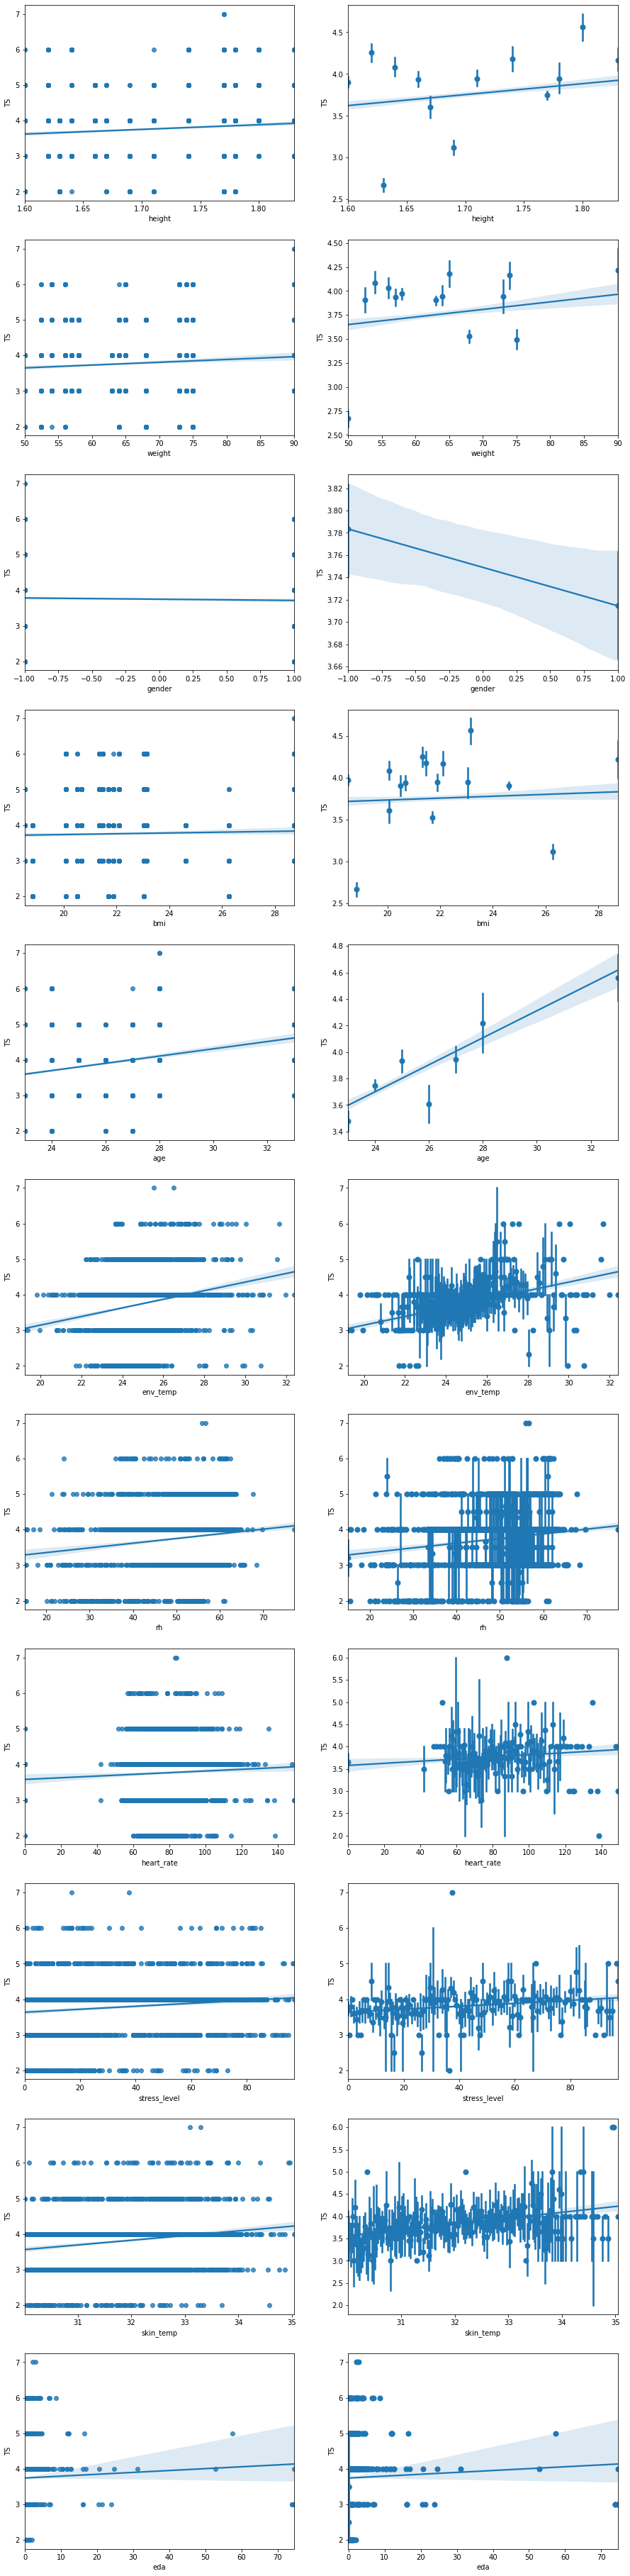

In [111]:
ns = ['height', 'weight', 'gender', 'bmi', 'age', 'env_temp', 'rh', 'heart_rate', 'stress_level', 'skin_temp', 'eda']
n_fig = len(ns)
plt.figure(figsize=(15, 6*n_fig))
i = 1
for n in ns:
    # left
    plt.subplot(n_fig, 2, i)
    sns.regplot(x=df_origin[n], y=df_origin['TS'])
    i += 1
    # right
    plt.subplot(n_fig, 2, i)
    sns.regplot(x=df_origin[n], y=df_origin['TS'], x_estimator=np.mean)
    i += 1

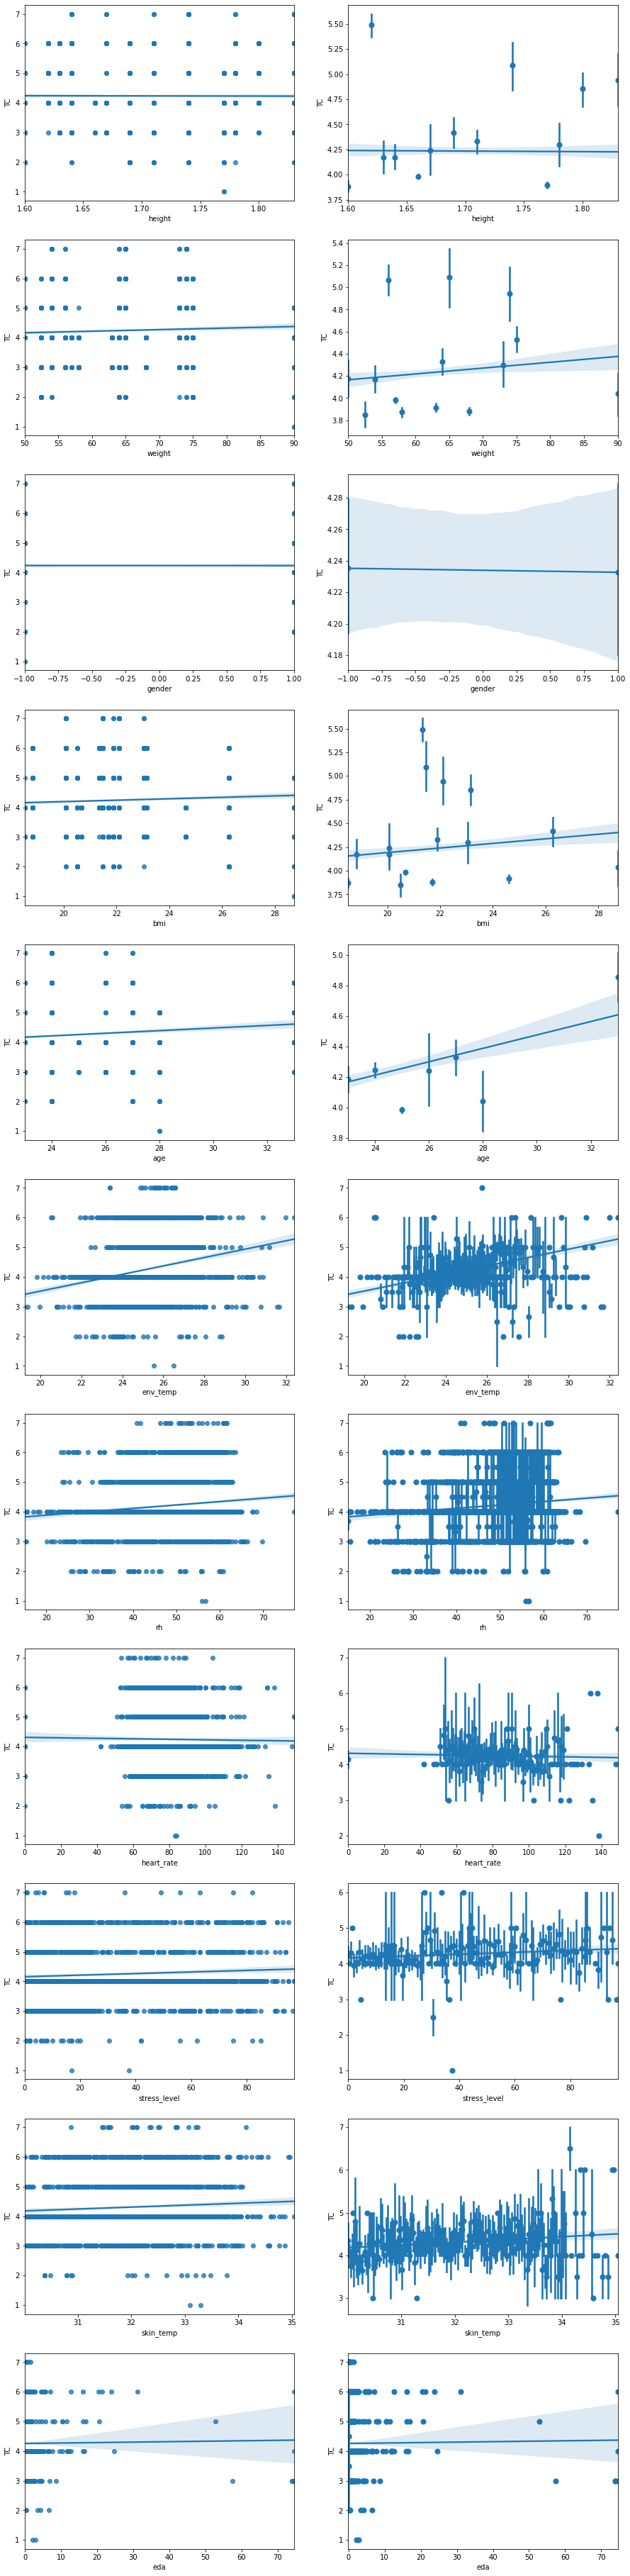

In [112]:
ns = ['height', 'weight', 'gender', 'bmi', 'age', 'env_temp', 'rh', 'heart_rate', 'stress_level', 'skin_temp', 'eda']
n_fig = len(ns)
plt.figure(figsize=(15, 6*n_fig))
i = 1
for n in ns:
    # left
    plt.subplot(n_fig, 2, i)
    sns.regplot(x=df_origin[n], y=df_origin['TC'])
    i += 1
    # right
    plt.subplot(n_fig, 2, i)
    sns.regplot(x=df_origin[n], y=df_origin['TC'], x_estimator=np.mean)
    i += 1

<AxesSubplot:xlabel='Act', ylabel='TC'>

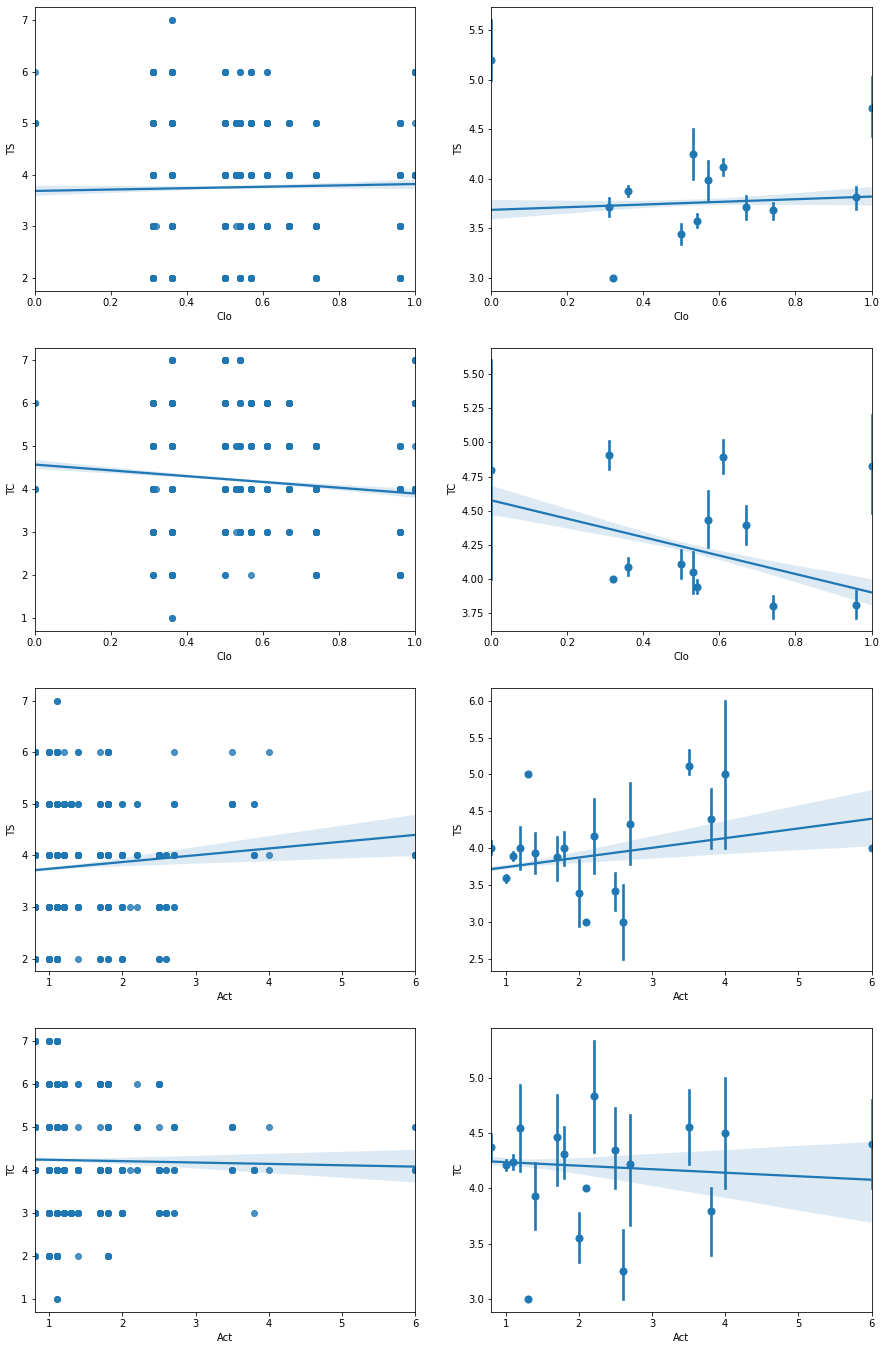

In [113]:
n_fig = 4
plt.figure(figsize=(15, 6*n_fig))
# left
plt.subplot(n_fig, 2, 1)
sns.regplot(x=df_origin['Clo'], y=df_origin['TS'])
# right
plt.subplot(n_fig, 2, 2)
sns.regplot(x=df_origin['Clo'], y=df_origin['TS'], x_estimator=np.mean)

# left
plt.subplot(n_fig, 2, 3)
sns.regplot(x=df_origin['Clo'], y=df_origin['TC'])
# right
plt.subplot(n_fig, 2, 4)
sns.regplot(x=df_origin['Clo'], y=df_origin['TC'], x_estimator=np.mean)

# left
plt.subplot(n_fig, 2, 5)
sns.regplot(x=df_origin['Act'], y=df_origin['TS'])
# right
plt.subplot(n_fig, 2, 6)
sns.regplot(x=df_origin['Act'], y=df_origin['TS'], x_estimator=np.mean)

# left
plt.subplot(n_fig, 2, 7)
sns.regplot(x=df_origin['Act'], y=df_origin['TC'])
# right
plt.subplot(n_fig, 2, 8)
sns.regplot(x=df_origin['Act'], y=df_origin['TC'], x_estimator=np.mean)

## data process

### choose data: TC < 4.0
|TC	| |
|---|---|
|1|	Very uncomfortable|
|2|	Uncomfortable|
|3|	Slightly uncomfortable|
|4|	Neutral|
|5|	Slightly comfortable|
|6|	Comfortable|
|7|	Very comfortable|

In [12]:
df_origin[df_origin[['TC']].isna().TC].shape
# some na in clo, means unrecorded data

(84, 16)

In [13]:
df_ts_nona = df_origin[df_origin['TC'].isna() ^ True]

In [14]:
df_ts_nona.shape

(2712, 16)

In [15]:
df_ts_edge = df_ts_nona[df_ts_nona['TC'] < 4.0]

In [16]:
df_ts_edge.shape

(394, 16)

In [17]:
df_ts_edge.head()

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TS,TC,Clo,Act
50,2020-10-21 02:30:00,1.64,54.0,1,20.077335,24,25.792778,61.044,81.0,7.0,32.552,0.169282,3.0,3.0,0.74,1.0
51,2020-10-21 03:00:00,1.64,54.0,1,20.077335,24,25.767778,61.040,65.0,2.0,32.474,0.171619,3.0,3.0,0.74,1.0
52,2020-10-21 03:30:00,1.64,54.0,1,20.077335,24,25.622778,60.745,NaN,0.0,32.889,0.177812,3.0,3.0,0.74,1.0
53,2020-10-21 04:00:00,1.64,54.0,1,20.077335,24,25.622778,60.835,58.0,0.0,32.292,0.172982,3.0,2.0,0.74,1.0
62,2020-10-21 16:00:00,1.64,54.0,1,20.077335,24,25.525000,61.636,70.0,20.0,32.059,0.263771,3.0,3.0,0.74,1.0


### choose data: TS > 4.0 

In [18]:
df_ts_edge[df_ts_edge[['TS']].isna().TS].shape

(0, 16)

In [19]:
df_TC_nona = df_ts_edge[df_ts_edge['TS'].isna() ^ True]

In [20]:
df_comfort_edge_high = df_TC_nona[df_TC_nona['TS'] > 4.0]

In [21]:
df_comfort_edge_high = df_comfort_edge_high[df_comfort_edge_high['TS'] < 7.0]

In [22]:
df_comfort_edge_high.shape

(49, 16)

In [23]:
df_comfort = df_comfort_edge_high
df_comfort

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TS,TC,Clo,Act
85,2020-10-19 13:30:00,1.77,90.0,-1,28.727377,28,26.377778,60.389,67.0,NaN,31.013,0.188456,6.0,3.0,0.36,1.1
86,2020-10-19 14:00:00,1.77,90.0,-1,28.727377,28,27.235000,60.400,84.0,42.0,33.790,6.623951,6.0,2.0,0.36,1.1
87,2020-10-19 14:30:00,1.77,90.0,-1,28.727377,28,26.792778,60.113,86.0,NaN,33.199,4.282520,6.0,2.0,0.36,1.1
88,2020-10-19 15:00:00,1.77,90.0,-1,28.727377,28,27.553889,59.860,94.0,75.0,33.482,3.446370,6.0,2.0,0.36,1.1
112,2020-10-20 14:30:00,1.77,90.0,-1,28.727377,28,25.866111,61.233,79.0,NaN,33.430,0.289664,6.0,3.0,0.57,1.4
113,2020-10-20 15:00:00,1.77,90.0,-1,28.727377,28,26.671111,61.459,83.0,78.0,30.537,0.422045,6.0,3.0,0.57,1.7
114,2020-10-20 15:30:00,1.77,90.0,-1,28.727377,28,27.235000,61.638,91.0,83.0,33.250,8.697113,6.0,3.0,0.36,1.1
128,2020-10-20 22:30:00,1.77,90.0,-1,28.727377,28,24.362778,59.548,135.0,NaN,31.458,57.415932,5.0,3.0,0.36,3.8
205,2020-10-20 22:30:00,1.77,58.0,-1,18.513199,23,26.377778,55.272,87.0,NaN,32.915,0.006857,5.0,3.0,0.36,1.0
416,2020-10-20 12:00:00,1.80,75.0,-1,23.148148,33,29.552222,48.290,67.0,17.0,31.850,4.085208,6.0,3.0,0.31,1.0


### visualization

In [24]:
df_visual = df_comfort[['height', 'weight', 'gender', 'bmi', 'age', 'rh', \
                      'heart_rate', 'stress_level', 'skin_temp', 'eda', \
                      'Clo', 'Act', 'env_temp']]

In [25]:
df_visual.head()

,height,weight,gender,bmi,age,rh,heart_rate,stress_level,skin_temp,eda,Clo,Act,env_temp
85,1.77,90.0,-1,28.727377,28,60.389,67.0,NaN,31.013,0.188456,0.36,1.1,26.377778
86,1.77,90.0,-1,28.727377,28,60.400,84.0,42.0,33.790,6.623951,0.36,1.1,27.235000
87,1.77,90.0,-1,28.727377,28,60.113,86.0,NaN,33.199,4.282520,0.36,1.1,26.792778
88,1.77,90.0,-1,28.727377,28,59.860,94.0,75.0,33.482,3.446370,0.36,1.1,27.553889
112,1.77,90.0,-1,28.727377,28,61.233,79.0,NaN,33.430,0.289664,0.57,1.4,25.866111


#### pairplot
download it to zoom in

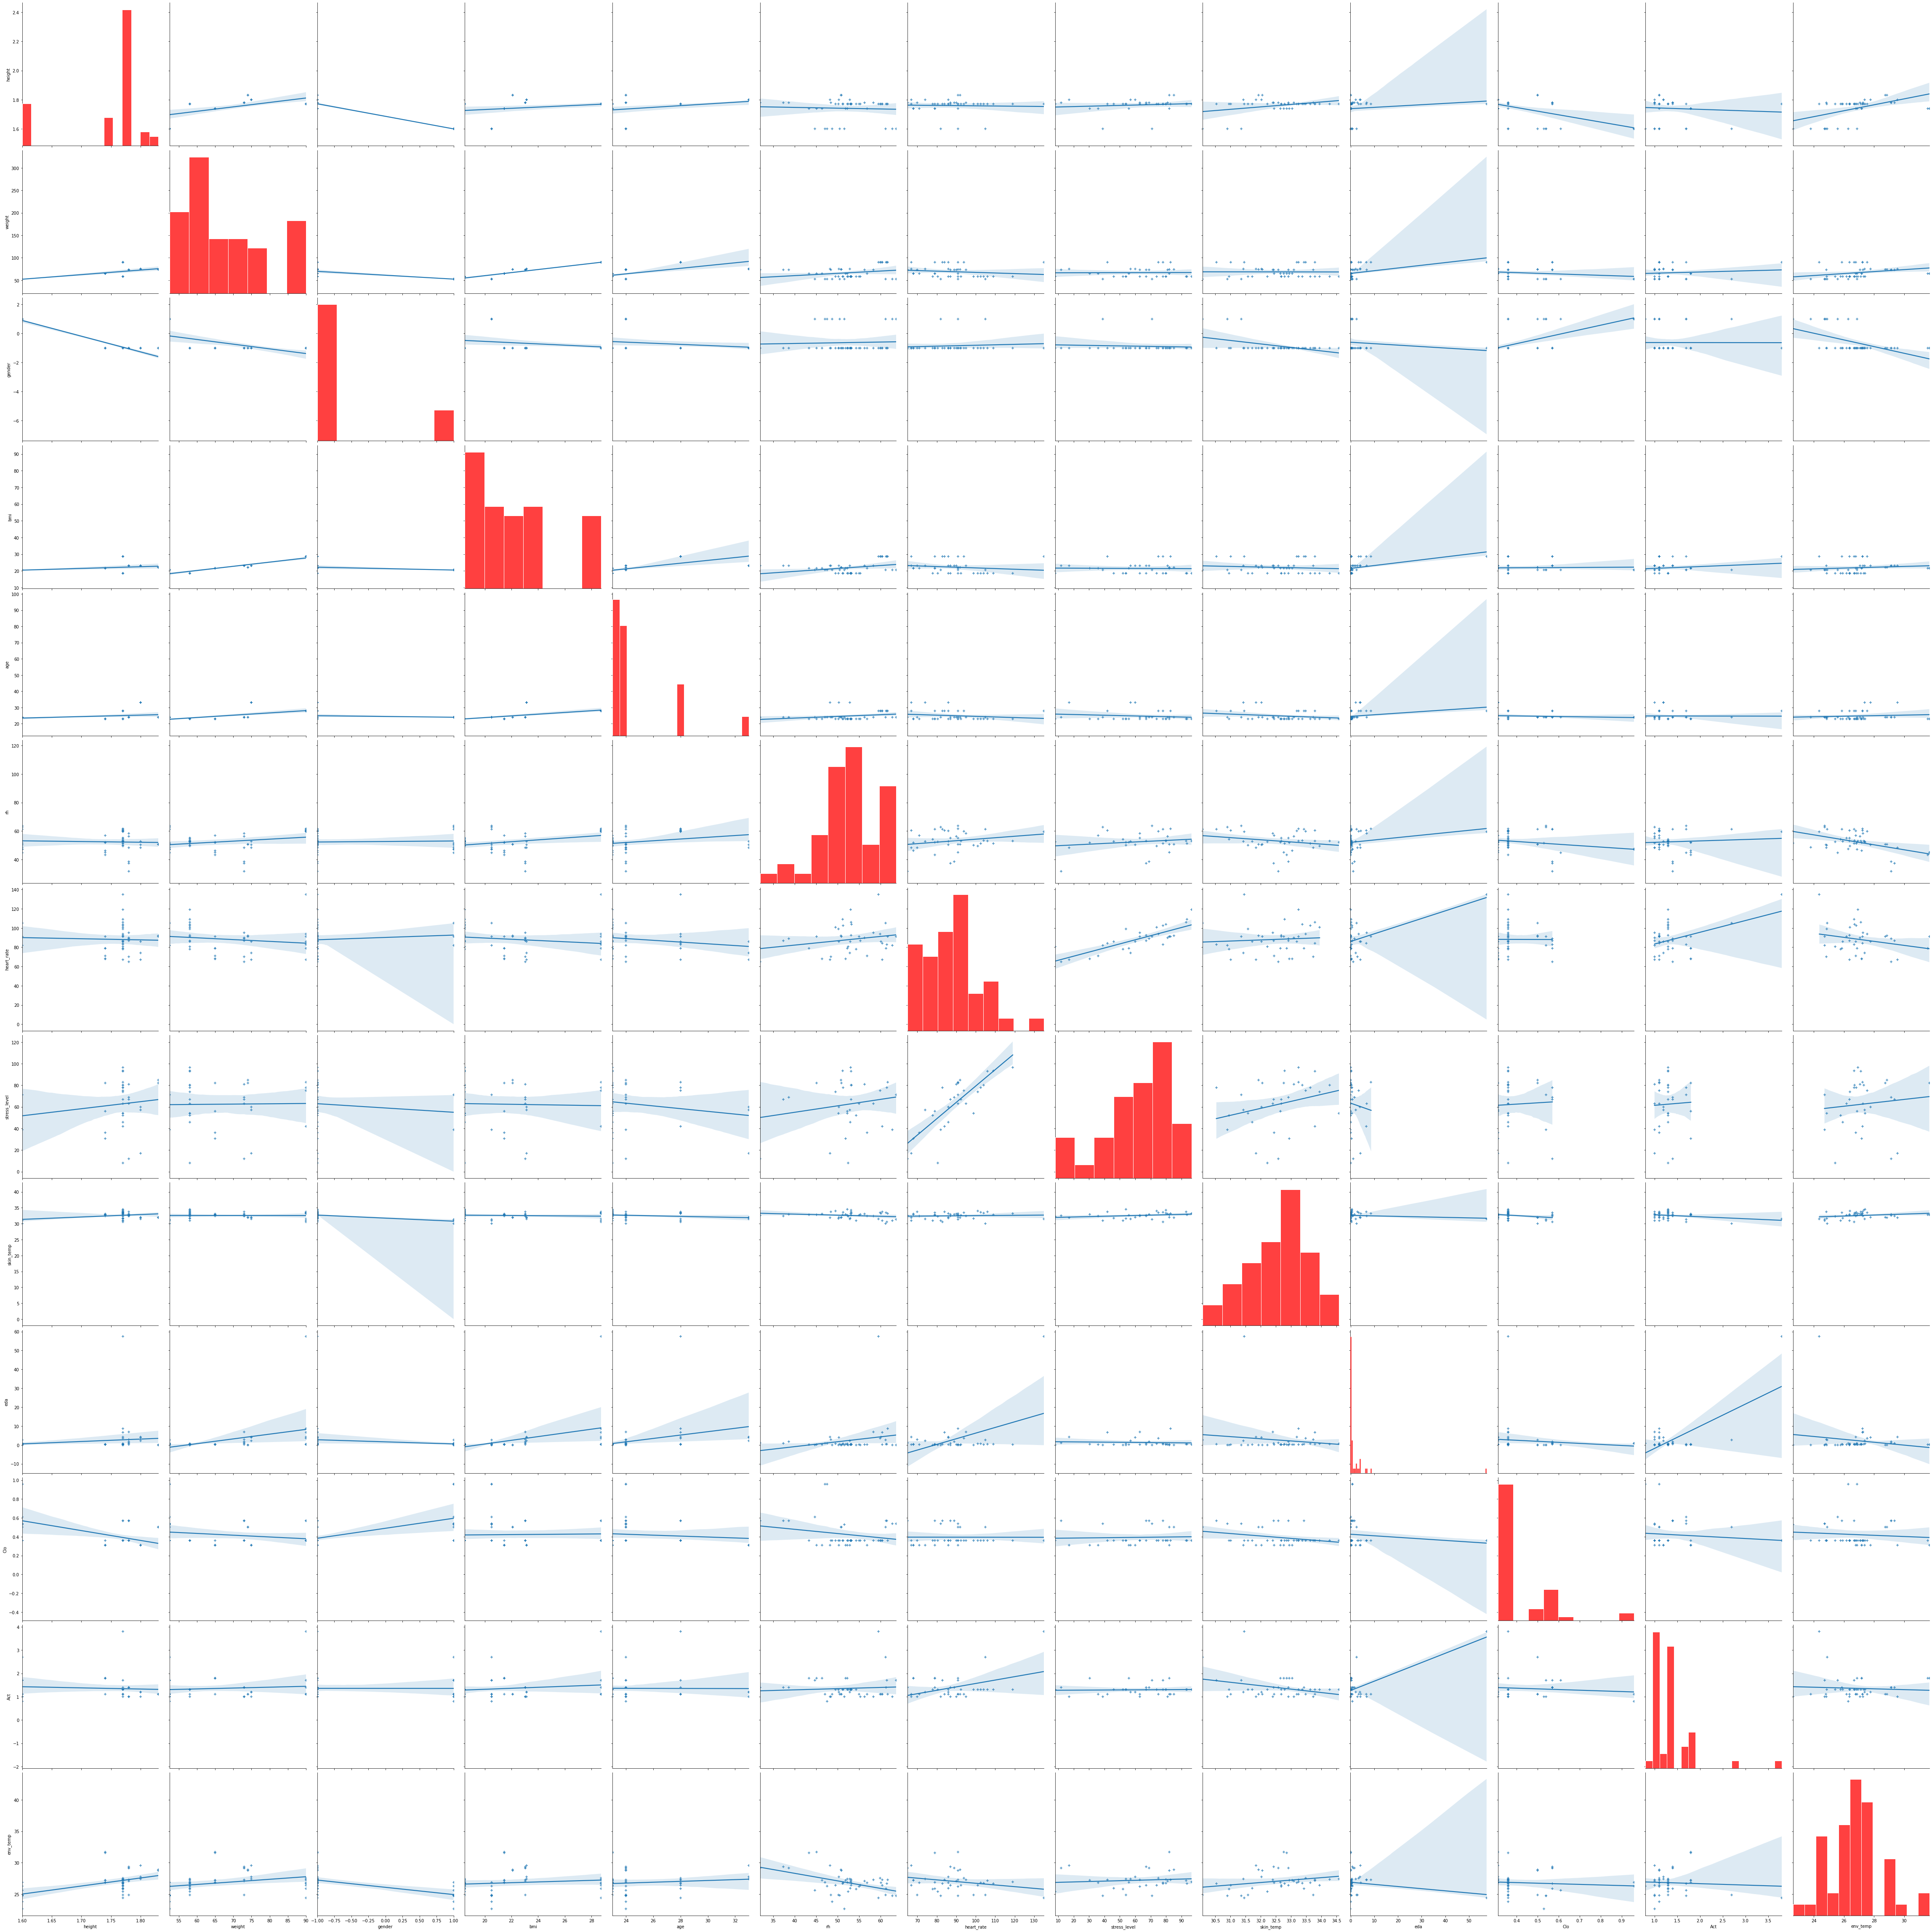

In [26]:
sns.pairplot(df_visual, dropna=True, kind='reg', markers='+', height=5, aspect=1,
            diag_kws=dict(edgecolor="w", color="r"))

#### correlation map

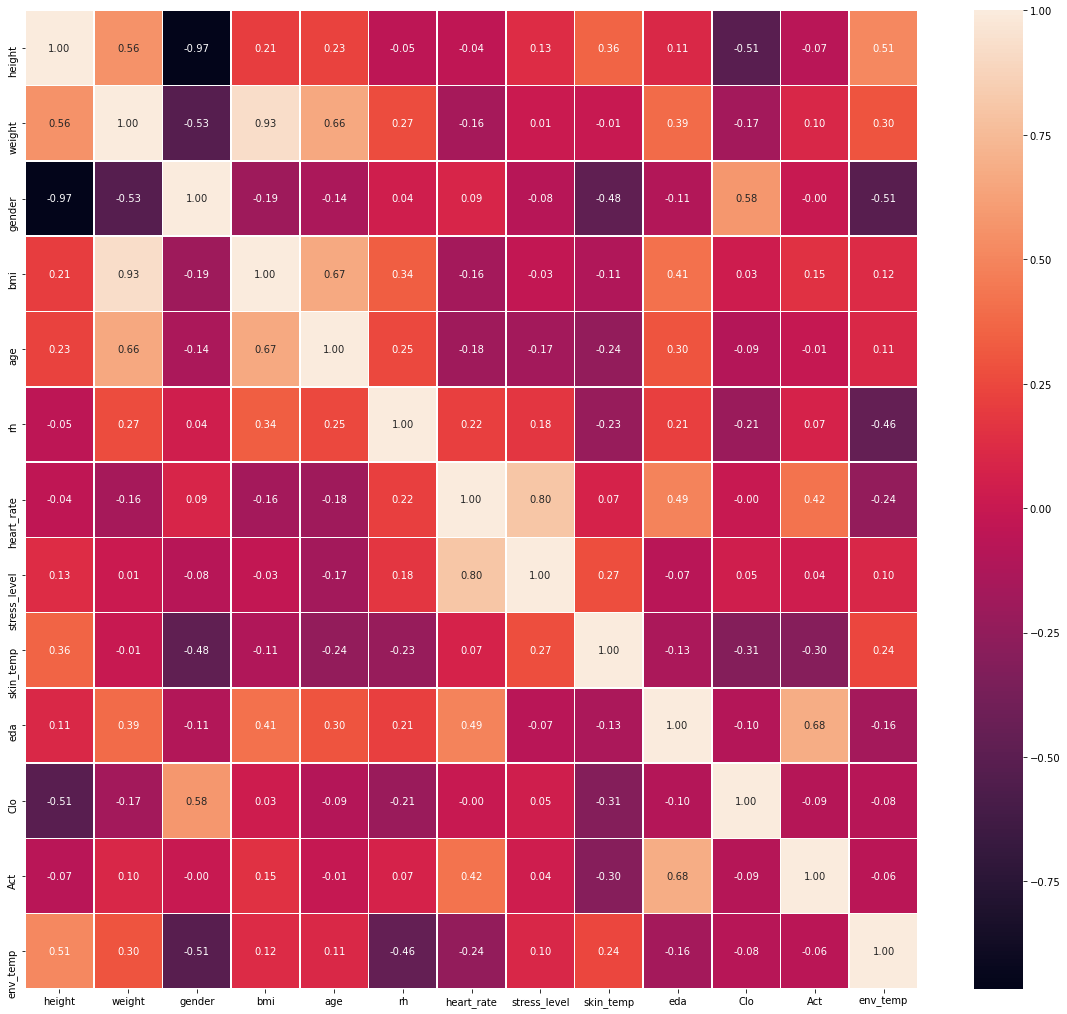

In [27]:
# correlation map
plt.rcParams["figure.figsize"] = (20, 18)
sns.heatmap(df_visual.corr(), annot=True, linewidths=.5, fmt= '.2f')
plt.show()

### shuffle

In [28]:
df_shuffle = df_comfort.sample(frac=1, random_state=1208).reset_index(drop=True)

In [29]:
X_data = df_shuffle[['height', 'weight', 'gender', 'bmi', 'age', 'rh', \
                      'heart_rate', 'stress_level', 'skin_temp', 'eda', \
                      'Clo', 'Act']]

In [30]:
X_cols_name = X_data.columns

In [31]:
y_data = df_shuffle['env_temp']

### imputation

In [32]:
df_comfort[df_comfort[['env_temp']].isna().env_temp]
# no na in env_temp

,time,height,weight,gender,bmi,age,env_temp,rh,heart_rate,stress_level,skin_temp,eda,TS,TC,Clo,Act


In [33]:
imp = SimpleImputer(strategy='mean')

In [34]:
X_data = pd.DataFrame(imp.fit_transform(X_data), columns=X_cols_name)

In [35]:
X_data_not_norm = pd.DataFrame(imp.fit_transform(X_data), columns=X_cols_name)

### normalize
linear regression need this. random forest doesn't need

In [36]:
X_array_normalize, X_norm = normalize(X_data, axis=0, return_norm=True)

In [37]:
X_data = pd.DataFrame(X_array_normalize, columns=X_cols_name)

In [38]:
X_data

,height,weight,gender,bmi,age,rh,heart_rate,stress_level,skin_temp,eda,Clo,Act
0,0.145155,0.122216,-0.142857,0.119346,0.131827,0.148479,0.145813,0.137864,0.143332,0.002157,0.115459,0.109211
1,0.131213,0.110626,0.142857,0.132204,0.137559,0.165250,0.168246,0.136737,0.131951,0.042911,0.160359,0.268064
2,0.145975,0.153823,-0.142857,0.148528,0.137559,0.152044,0.144211,0.177253,0.145148,0.001334,0.115459,0.099283
3,0.145155,0.189645,-0.142857,0.185192,0.160485,0.165946,0.132994,0.170688,0.133925,0.007079,0.182810,0.168781
4,0.131213,0.110626,0.142857,0.132204,0.137559,0.120644,0.141260,0.136737,0.142796,0.000535,0.195638,0.168781
5,0.131213,0.110626,0.142857,0.132204,0.137559,0.169470,0.131392,0.085344,0.135547,-0.000534,0.173188,0.099283
6,0.145155,0.189645,-0.142857,0.185192,0.160485,0.166430,0.145813,0.181630,0.145823,0.145887,0.115459,0.109211
7,0.145155,0.122216,-0.142857,0.119346,0.131827,0.149241,0.139404,0.136737,0.144354,0.000115,0.115459,0.099283
8,0.145155,0.189645,-0.142857,0.185192,0.160485,0.160787,0.216316,0.136737,0.137964,0.963103,0.115459,0.377275
9,0.145155,0.122216,-0.142857,0.119346,0.131827,0.135646,0.158632,0.118169,0.138534,0.000300,0.115459,0.129068


In [39]:
X_norm

array([ 12.19387141, 474.57059538,   7.        , 155.12239897,
       174.4706279 , 370.35432569, 624.0874703 , 456.97366414,
       228.01611338,  59.61554069,   3.11799615,  10.07223908])

## refine data

In [40]:
regr = sm.OLS(y_data, X_data)
regr_fit = regr.fit()

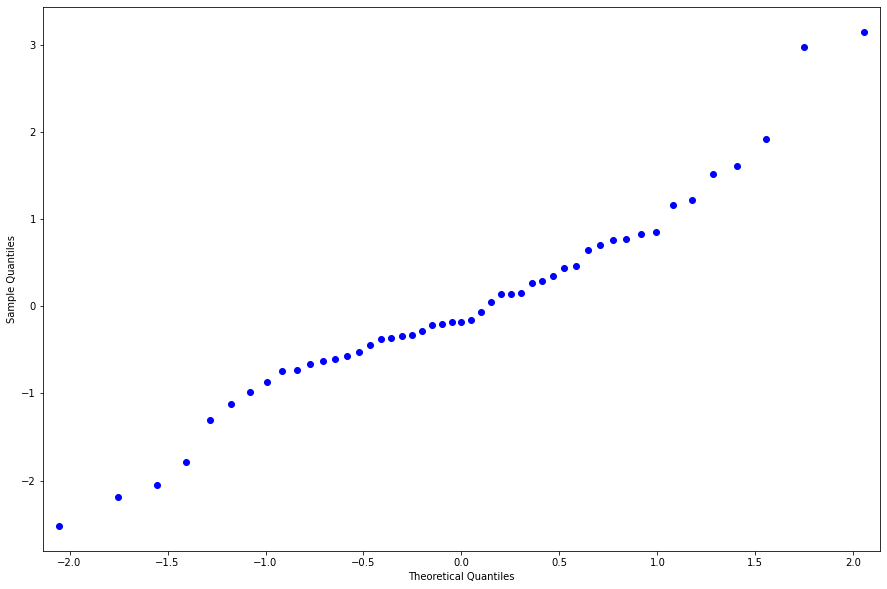

In [41]:
plt.rcParams["figure.figsize"] = (15, 10)
sm.qqplot(regr_fit.resid)
plt.show()

### leverage & outlier

In [42]:
infl = regr_fit.get_influence()

In [43]:
# leverage
leviers = infl.hat_matrix_diag
# list(leviers)

In [44]:
# studentized residue
res_studs = infl.resid_studentized_external
# list(res_studs)

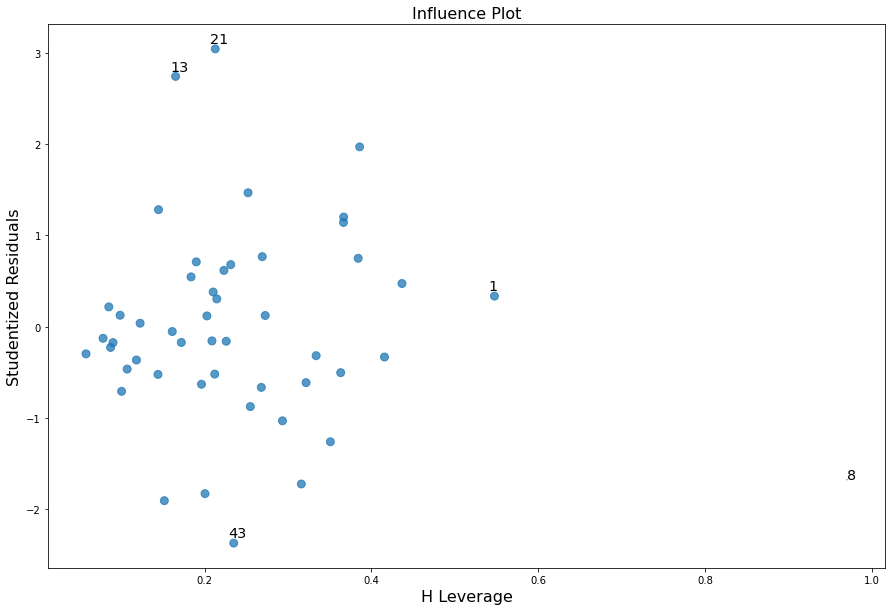

In [45]:
plt.rcParams["figure.figsize"] = (15, 10)
sm.graphics.influence_plot(regr_fit, size=0.5)
plt.show()

### leverage detection
the threshold value may be:
$$s_h=2\times \frac{p+1}{n}$$

In [46]:
n_data = X_data.shape[0]
p_data = X_data.shape[1]

In [47]:
s_h = 2 * (p_data + 1) / n_data
s_h

0.5306122448979592

In [48]:
atyp_levier = leviers > s_h

In [49]:
len(leviers[atyp_levier])

2

### outlier detection
Threshold:
$$s_t=t_{1-0.05/2}(n-p-2)$$

In [50]:
seuil_stud = scipy.stats.t.ppf(0.975, df=n_data-p_data-2)
seuil_stud

2.0301079282503425

In [51]:
atyp_stud = np.abs(res_studs) > seuil_stud
atyp_stud

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False])

In [52]:
idx_eliminate_lvg_outl = np.logical_not(np.logical_or(atyp_levier, atyp_stud))

In [53]:
X_data.index[idx_eliminate_lvg_outl]

Int64Index([ 0,  2,  3,  4,  5,  6,  7,  9, 10, 11, 12, 14, 15, 16, 17, 18, 19,
            20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37,
            38, 39, 40, 41, 42, 44, 45, 46, 47, 48],
           dtype='int64')

In [54]:
X_data_refine = X_data[idx_eliminate_lvg_outl]
y_data_refine = y_data[idx_eliminate_lvg_outl]

### save refine data (not normalized)

In [55]:
X_data_refine_not_norm = X_data_not_norm[idx_eliminate_lvg_outl]
y_data_refine_not_norm = y_data[idx_eliminate_lvg_outl]

In [56]:
df_refine_not_norm = pd.concat([X_data_refine_not_norm, y_data_refine_not_norm], axis=1)

In [57]:
df_refine_not_norm.to_csv('../processed_data/train_refine_not_norm_max.csv', index=False)

In [58]:
df_refine_not_norm

,height,weight,gender,bmi,age,rh,heart_rate,stress_level,skin_temp,eda,Clo,Act,env_temp
0,1.77,58.0,-1.0,18.513199,23.0,54.990,91.000000,63.000000,32.682000,0.128582,0.36,1.1,26.157778
2,1.78,73.0,-1.0,23.040020,24.0,56.310,90.000000,81.000000,33.096000,0.079552,0.36,1.0,27.075000
3,1.77,90.0,-1.0,28.727377,28.0,61.459,83.000000,78.000000,30.537000,0.422045,0.57,1.7,26.671111
4,1.60,52.5,1.0,20.507812,24.0,44.681,88.158537,62.485294,32.559814,0.031869,0.61,1.7,25.573889
5,1.60,52.5,1.0,20.507812,24.0,62.764,82.000000,39.000000,30.907000,-0.031865,0.54,1.0,24.702222
6,1.77,90.0,-1.0,28.727377,28.0,61.638,91.000000,83.000000,33.250000,8.697113,0.36,1.1,27.235000
7,1.77,58.0,-1.0,18.513199,23.0,55.272,87.000000,62.485294,32.915000,0.006857,0.36,1.0,26.377778
9,1.77,58.0,-1.0,18.513199,23.0,50.237,99.000000,54.000000,31.588000,0.017909,0.36,1.3,24.847222
10,1.77,90.0,-1.0,28.727377,28.0,60.389,67.000000,62.485294,31.013000,0.188456,0.36,1.1,26.377778
11,1.77,58.0,-1.0,18.513199,23.0,53.132,106.000000,93.000000,33.790000,0.322940,0.36,1.3,27.136111


## linear regression
try after refine

In [59]:
n_rows = y_data_refine.shape[0]

train_test_fraction = 0.8
n_rows_train = int(n_rows * train_test_fraction)
# n_rows_test = n_rows - n_rows_train

X_train = X_data_refine[:n_rows_train]
y_train = y_data_refine[:n_rows_train]

X_test = X_data_refine[n_rows_train:]
y_test = y_data_refine[n_rows_train:]

In [60]:
regr = sm.OLS(y_train, X_train)

In [61]:
regr_fit = regr.fit()

In [62]:
y_pred = regr_fit.predict(X_test)

In [63]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

,Actual,Predicted
39,27.407222,27.400201
40,26.402222,27.053980
41,26.377778,26.812923
42,29.152222,28.798998
44,27.763889,28.177544
45,25.792778,26.870849
46,27.172778,27.497738
47,25.403889,26.644762
48,26.817778,26.894660


In [64]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              2973.
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                    1.05e-33
Time:                        21:32:06   Log-Likelihood:                         -36.059
No. Observations:                  35   AIC:                                      96.12
Df Residuals:                      23   BIC:                                      114.8
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height         182.3411     58.770      3.103      0.005      60.765     303.917
weight          65.9393     82.200      0.802      0.431    -104.104     235.982
gender           5.5470      6.496      0.854      0.402      -7.891      18.985
bmi            -78.8475     83.749     -0.941      0.356    -252.096      94.401
age              1.0463     15.571      0.067      0.947     -31.165      33.257
rh             -19.1655     11.479     -1.670      0.109     -42.911       4.580
heart_rate     -26.5889     17.104     -1.555      0.134     -61.972       8.794
stress_level     4.8086      7.137      0.674      0.507      -9.955      19.572
skin_temp       43.3319     50.944      0.851      0.404     -62.055     148.718
eda             13.2383      6.211      2.132      0.044       0.391      26.086
Clo              9.8173      4.038      2.431      0.023       1.464      18.171
Act              7.5502      7.024      1.075      0.294      -6.979      22.080
==============================================================================
Omnibus:                        5.637   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                4.143
Skew:                          -0.769   Prob(JB):                        0.126
Kurtosis:                       3.689   Cond. No.                         414.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
# mean squared error
mean_squared_error(y_test, y_pred)

0.4137311634751977

In [66]:
# R2 score
r2_score(y_test, y_pred)

0.6327107361671509

## feature selection
seems many features are unrelated with a multi linear regression model

### correlation map for refine data

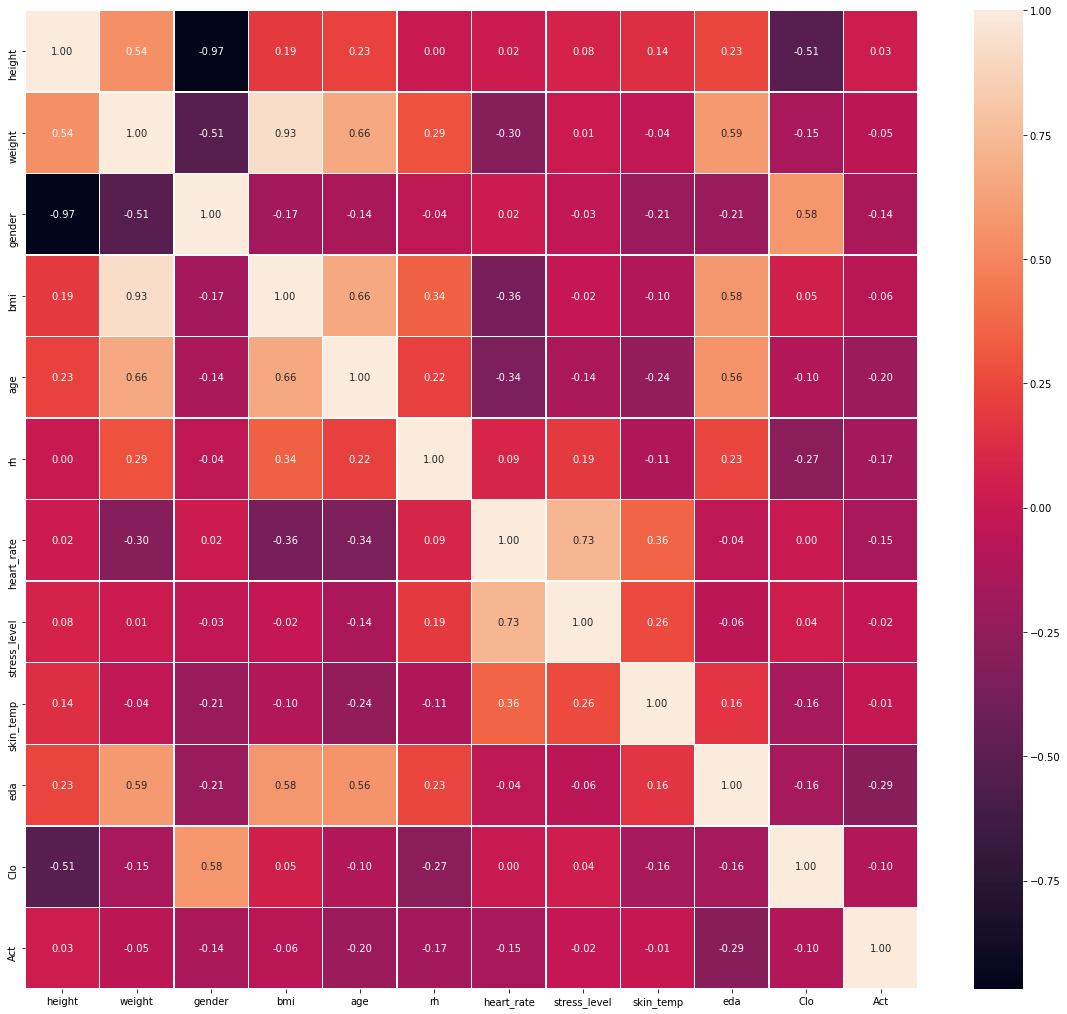

In [67]:
plt.rcParams["figure.figsize"] = (20, 18)
sns.heatmap(X_data_refine.corr(), annot=True, linewidths=.5, fmt= '.2f')
plt.show()

### backward selection

In [68]:
regr = sm.OLS(y_data_refine, X_data_refine)
regr_fit = regr.fit()

In [69]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              4516.
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                    4.40e-48
Time:                        21:32:06   Log-Likelihood:                         -43.478
No. Observations:                  44   AIC:                                      111.0
Df Residuals:                      32   BIC:                                      132.4
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height         172.1695     43.648      3.944      0.000      83.261     261.078
weight          68.0781     66.292      1.027      0.312     -66.954     203.110
gender           5.8283      5.657      1.030      0.311      -5.694      17.351
bmi            -75.8123     67.732     -1.119      0.271    -213.778      62.153
age              0.4600     12.298      0.037      0.970     -24.590      25.510
rh             -22.5436      9.058     -2.489      0.018     -40.995      -4.092
heart_rate     -27.5680     12.511     -2.204      0.035     -53.052      -2.084
stress_level     7.1251      4.696      1.517      0.139      -2.440      16.690
skin_temp       51.8019     38.275      1.353      0.185     -26.163     129.766
eda             12.9309      5.294      2.443      0.020       2.148      23.714
Clo              9.6941      3.633      2.668      0.012       2.293      17.095
Act              6.4612      6.197      1.043      0.305      -6.162      19.084
==============================================================================
Omnibus:                        4.240   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.120   Jarque-Bera (JB):                3.113
Skew:                          -0.457   Prob(JB):                        0.211
Kurtosis:                       3.928   Cond. No.                         397.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
X_rm = X_data_refine

#### remove age

In [71]:
X_rm = X_rm.drop(columns='age')

In [72]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              5080.
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                    5.99e-50
Time:                        21:32:06   Log-Likelihood:                         -43.479
No. Observations:                  44   AIC:                                      109.0
Df Residuals:                      33   BIC:                                      128.6
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height         172.8031     39.614      4.362      0.000      92.208     253.398
weight          68.6870     63.282      1.085      0.286     -60.060     197.434
gender           5.9211      5.006      1.183      0.245      -4.263      16.105
bmi            -76.2934     65.486     -1.165      0.252    -209.525      56.938
rh             -22.5341      8.917     -2.527      0.016     -40.675      -4.393
heart_rate     -27.6382     12.181     -2.269      0.030     -52.420      -2.856
stress_level     7.1210      4.623      1.540      0.133      -2.284      16.526
skin_temp       51.6420     37.456      1.379      0.177     -24.563     127.846
eda             12.9878      4.993      2.601      0.014       2.830      23.146
Clo              9.6608      3.469      2.785      0.009       2.603      16.718
Act              6.4699      6.098      1.061      0.296      -5.937      18.877
==============================================================================
Omnibus:                        4.215   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                3.095
Skew:                          -0.452   Prob(JB):                        0.213
Kurtosis:                       3.933   Cond. No.                         374.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove weight

In [73]:
X_rm = X_rm.drop(columns='weight')

In [74]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              5559.
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                    1.39e-51
Time:                        21:32:06   Log-Likelihood:                         -44.251
No. Observations:                  44   AIC:                                      108.5
Df Residuals:                      34   BIC:                                      126.3
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
height         200.7195     30.208      6.645      0.000     139.329     262.110
gender           0.9580      2.042      0.469      0.642      -3.193       5.109
bmi             -5.9178      9.217     -0.642      0.525     -24.649      12.814
rh             -26.9626      7.949     -3.392      0.002     -43.117     -10.808
heart_rate     -27.3862     12.211     -2.243      0.032     -52.201      -2.571
stress_level     8.5678      4.438      1.930      0.062      -0.452      17.587
skin_temp       24.2846     27.779      0.874      0.388     -32.170      80.739
eda             13.8762      4.938      2.810      0.008       3.841      23.912
Clo              9.5993      3.477      2.760      0.009       2.532      16.666
Act              3.1597      5.295      0.597      0.555      -7.601      13.920
==============================================================================
Omnibus:                        3.972   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.137   Jarque-Bera (JB):                2.812
Skew:                          -0.455   Prob(JB):                        0.245
Kurtosis:                       3.839   Cond. No.                         141.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove stress_level

In [75]:
X_rm = X_rm.drop(columns='stress_level')

In [76]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              5730.
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                    1.04e-52
Time:                        21:32:07   Log-Likelihood:                         -46.539
No. Observations:                  44   AIC:                                      111.1
Df Residuals:                      35   BIC:                                      127.1
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
height       186.1895     30.374      6.130      0.000     124.527     247.852
gender         0.1413      2.075      0.068      0.946      -4.070       4.353
bmi            1.8076      8.620      0.210      0.835     -15.693      19.308
rh           -27.0701      8.253     -3.280      0.002     -43.824     -10.316
heart_rate    -9.1197      8.013     -1.138      0.263     -25.386       7.147
skin_temp     21.2459     28.795      0.738      0.466     -37.211      79.703
eda           10.8497      4.862      2.232      0.032       0.980      20.719
Clo            9.5129      3.610      2.635      0.012       2.184      16.842
Act            3.5437      5.493      0.645      0.523      -7.608      14.696
==============================================================================
Omnibus:                        7.514   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                6.355
Skew:                          -0.847   Prob(JB):                       0.0417
Kurtosis:                       3.771   Cond. No.                         132.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove bmi

In [77]:
X_rm = X_rm.drop(columns='bmi')

In [78]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              6622.
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                    1.25e-54
Time:                        21:32:07   Log-Likelihood:                         -46.567
No. Observations:                  44   AIC:                                      109.1
Df Residuals:                      36   BIC:                                      123.4
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
height       187.4714     29.355      6.386      0.000     127.938     247.005
gender         0.1159      2.043      0.057      0.955      -4.028       4.260
rh           -26.2274      7.112     -3.688      0.001     -40.651     -11.804
heart_rate    -9.9100      6.976     -1.420      0.164     -24.059       4.239
skin_temp     21.0874     28.400      0.743      0.463     -36.511      78.686
eda           11.4639      3.828      2.995      0.005       3.700      19.228
Clo            9.8358      3.222      3.053      0.004       3.302      16.369
Act            3.7470      5.335      0.702      0.487      -7.072      14.566
==============================================================================
Omnibus:                        7.342   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.025   Jarque-Bera (JB):                6.180
Skew:                          -0.845   Prob(JB):                       0.0455
Kurtosis:                       3.720   Cond. No.                         121.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove skin_temp

In [79]:
X_rm = X_rm.drop(columns='skin_temp')

In [80]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              7660.
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                    1.80e-56
Time:                        21:32:07   Log-Likelihood:                         -46.901
No. Observations:                  44   AIC:                                      107.8
Df Residuals:                      37   BIC:                                      120.3
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
height       207.2093     12.376     16.743      0.000     182.133     232.286
gender         1.0434      1.607      0.649      0.520      -2.213       4.300
rh           -26.6744      7.043     -3.787      0.001     -40.945     -12.403
heart_rate    -8.0602      6.477     -1.244      0.221     -21.184       5.063
eda           11.9434      3.750      3.185      0.003       4.344      19.542
Clo            9.6076      3.187      3.014      0.005       3.149      16.066
Act            4.5914      5.180      0.886      0.381      -5.905      15.088
==============================================================================
Omnibus:                        7.854   Durbin-Watson:                   2.079
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                6.787
Skew:                          -0.900   Prob(JB):                       0.0336
Kurtosis:                       3.679   Cond. No.                         39.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### remove heart_rate

In [81]:
X_rm = X_rm.drop(columns='heart_rate')

In [82]:
regr = sm.OLS(y_data_refine, X_rm)
regr_fit = regr.fit()
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              8810.
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                    3.91e-58
Time:                        21:32:07   Log-Likelihood:                         -47.803
No. Observations:                  44   AIC:                                      107.6
Df Residuals:                      38   BIC:                                      118.3
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
height       199.0308     10.562     18.843      0.000     177.648     220.413
gender         0.6551      1.588      0.413      0.682      -2.559       3.870
rh           -27.4951      7.063     -3.893      0.000     -41.793     -13.197
eda           12.4601      3.754      3.319      0.002       4.860      20.060
Clo            9.6407      3.210      3.003      0.005       3.142      16.139
Act            5.4559      5.171      1.055      0.298      -5.011      15.923
==============================================================================
Omnibus:                        6.963   Durbin-Watson:                   2.204
Prob(Omnibus):                  0.031   Jarque-Bera (JB):                5.755
Skew:                          -0.758   Prob(JB):                       0.0563
Kurtosis:                       3.918   Cond. No.                         31.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## linear regression (final try)

### single linear regression

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_rm, y_data_refine, test_size=0.2, random_state=1208)

In [84]:
n_features = X_train.shape[1]

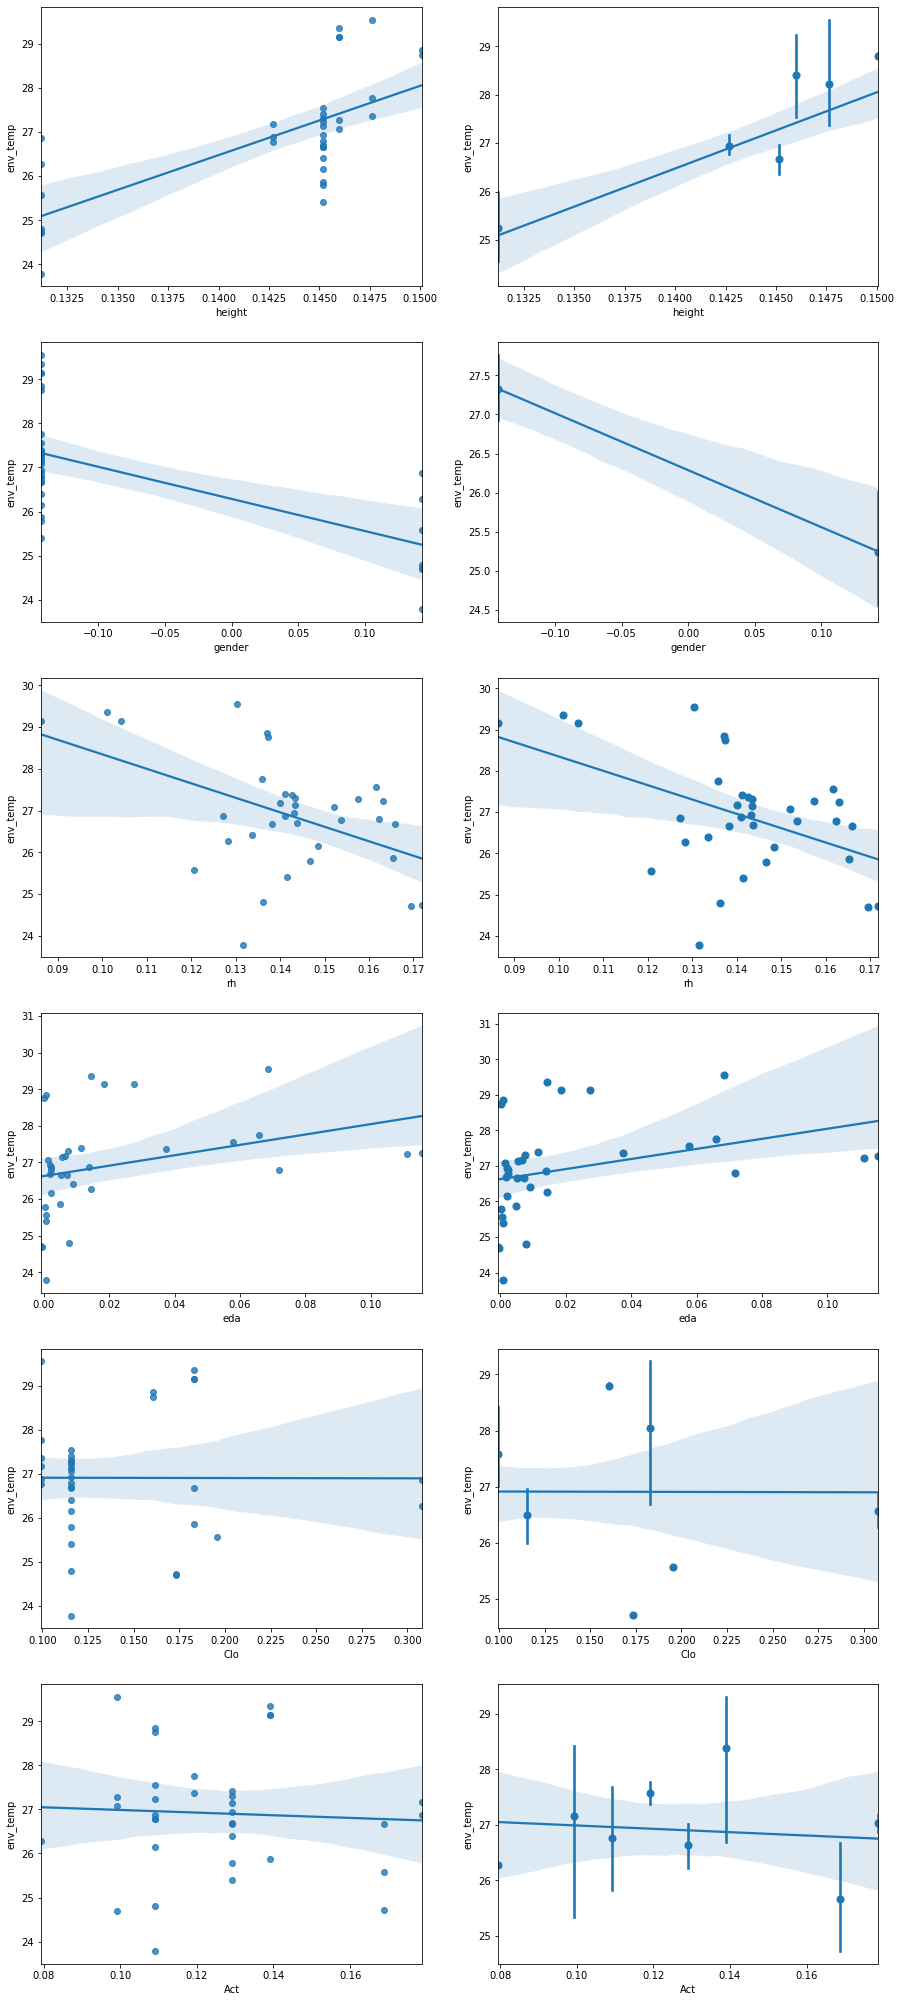

In [85]:
plt.figure(figsize=(15, 6*n_features))
i = 1
for col_n in X_train.columns:
    # left
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train)
    i += 1
    
    # right
    plt.subplot(n_features, 2, i)
    sns.regplot(x=X_train[col_n], y=y_train, x_estimator=np.mean)
    i += 1

### multiple linear regression

In [86]:
regr = sm.OLS(y_train, X_train)

In [87]:
regr_fit = regr.fit()

In [88]:
y_pred = regr_fit.predict(X_test)

In [89]:
pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

,Actual,Predicted
41,26.377778,26.833053
46,27.172778,26.855469
15,25.913889,26.848170
6,27.235000,27.727977
48,26.817778,27.073617
30,22.608889,24.944706
7,26.377778,26.587400
10,26.377778,26.247138
9,24.847222,27.045466


In [90]:
regr_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               env_temp   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              9958.
Date:                Thu, 28 Jan 2021   Prob (F-statistic):                    1.13e-46
Time:                        21:32:10   Log-Likelihood:                         -31.402
No. Observations:                  35   AIC:                                      74.80
Df Residuals:                      29   BIC:                                      84.14
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
height       206.5885      9.300     22.215      0.000     187.569     225.608
gender         1.8652      1.427      1.307      0.201      -1.053       4.783
rh           -28.6642      6.219     -4.609      0.000     -41.383     -15.945
eda           11.0527      4.027      2.745      0.010       2.817      19.288
Clo            7.9858      2.771      2.882      0.007       2.319      13.652
Act            2.2268      4.914      0.453      0.654      -7.824      12.278
==============================================================================
Omnibus:                        0.763   Durbin-Watson:                   2.179
Prob(Omnibus):                  0.683   Jarque-Bera (JB):                0.606
Skew:                          -0.309   Prob(JB):                        0.739
Kurtosis:                       2.819   Cond. No.                         29.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
# mean squared error
mean_squared_error(y_test, y_pred)

1.3154052317051061

In [92]:
# R2 score
r2_score(y_test, y_pred)

0.29637911867765954

## cross validation

In [93]:
from sklearn import metrics
# metrics
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [94]:
lr = LinearRegression()
lr_cv_mse = cross_val_score(lr, X_rm, y_data_refine, scoring='neg_mean_squared_error', cv=10)

In [95]:
lr_cv_mse

array([-0.49782999, -0.99148406, -1.04534972, -0.49722548, -0.27315055,
       -1.83795457, -0.78587381, -0.09374431, -0.1839319 , -0.72838697])

In [96]:
np.abs(lr_cv_mse.mean())

0.6934931358337133